In [1]:
import torch
from torch import einsum
from acetn.evolution.full_update import *
from acetn.ipeps.ipeps_config import EvolutionConfig

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 16,
    'figure.titlesize': 20,
})

## Setup Heisenberg model iPEPS

In [3]:
from acetn.ipeps import Ipeps
from acetn.evolution.gate import Gate
from acetn.model.model_factory import model_factory

def setup_ipeps_and_gate(dtau):
    config = {'dtype': "float64",
              'device': "cuda",
              'TN': {'nx':2, 'ny':2, 'dims':{'phys':2, 'bond':4, 'chi':16}}, 
              'model': {'name':'heisenberg', 'params':{'J':1.0}},
              }
    ipeps = Ipeps(config)
    model = model_factory.create(ipeps.config.model)
    gate = Gate(model, dtau, ipeps.bond_list, ipeps.site_list)

    class EvolutionConfig:
        backend = "cutensor"
        tensor_solver = "als"
        als_niter = 100
        als_tol = 1e-15
        als_method = "cholesky"
        als_epsilon = 1e-12
        use_gauge_fix = True
        gauge_fix_atol = 1e-12
        positive_approx_cutoff = 1e-12
    evolution_config = EvolutionConfig()

    return ipeps, gate, evolution_config

In [4]:
from acetn.evolution.full_update import *
dtau = 0.1
ipeps, gate, config = setup_ipeps_and_gate(dtau=dtau)

Starting iPEPS calculation with config:
----------------------------------------
dtype = "float64"
device = "cuda"

[TN]
nx = 2
ny = 2

[model]
name = "heisenberg"

[TN.dims]
phys = 2
bond = 4
chi = 16

[model.params]
J = 1.0
----------------------------------------
Initializing iPEPS...


## Evolve 10 steps

In [5]:
ipeps.evolve(steps=10, dtau=dtau)
ipeps.measure()

Start imaginary-time evolution with dtau=0.1...
Bond dimensions:
(D, chi): (4, 16)
Model parameters:
J: 1.0


Renormalizing boundary tensors: 40 sweeps [00:03, 11.42 sweeps/s]
Updating tensors: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.92it/s]


Finished imaginary-time evolution
Total runtime: 3.426576 seconds


Renormalizing boundary tensors: 40 sweeps [00:03, 10.34 sweeps/s]


Calculated one-site measurements:
site	sx        	sz        
(0, 0)	0.00338781	0.78383583
(0, 1)	-0.00037897	0.78384182
(1, 0)	0.00038051	0.78384301
(1, 1)	0.00188498	0.78383960
Measurement averages:
Energy: -0.6638725534631091
sx: 0.0013185804164119598
sz: 0.783840064564953


{'Energy': tensor(-0.6639, device='cuda:0', dtype=torch.float64),
 'sx': tensor(0.0013, device='cuda:0', dtype=torch.float64),
 'sz': tensor(0.7838, device='cuda:0', dtype=torch.float64)}

## Function for calculating norm tensor condition number

In [6]:
def condition_number(n12):
    nD = n12.shape[0]
    U, S, Vh = torch.linalg.svd(n12.reshape(nD**2, nD**2))
    cond_number = S.max() / S.min()
    return cond_number.item()

## Initialize Norm Tensor

In [7]:
dtau = 0.01

model = model_factory.create(ipeps.config.model)
gate = Gate(model, dtau, ipeps.bond_list, ipeps.site_list)
full_updater = FullUpdater(ipeps, gate, config)

bond = [(0, 0), (0, 1), 2]
s1,s2,k = bond
a1 = ipeps[s1]['A']
a2 = ipeps[s2]['A']
a1,a2 = full_updater.permute_bond_tensors(a1, a2, k)

pD = ipeps.dims["phys"]
bD = ipeps.dims["bond"]

a1q,a1r,a2q,a2r = full_updater.decompose_site_tensors(a1, a2)
n12 = full_updater.build_norm_tensor(ipeps, bond, a1q, a2q)

gate = full_updater.gate[bond]

a12g = einsum("yup,xuq->ypxq", a1r, a2r)
a12g = einsum("ypxq,pqrs->yxrs", a12g, gate)

print("Initial condition_number:")
print("k(n12):", condition_number(n12))

Initial condition_number:
k(n12): 3623787.3888083794


## Enforce Norm Tensor Hermitian

In [8]:
n12_mH = 0.5*(n12 + einsum("yxYX->YXyx", conj(n12)))
print("condition_number after enforcing Hermitian:")
print("k(n12_mH):", condition_number(n12_mH))

condition_number after enforcing Hermitian:
k(n12_mH): 3623737.1274476512


## Positive Approximation (Standard)

In [9]:
nD = n12.shape[0]
nw, nz = torch.linalg.eigh(n12_mH.reshape(nD**2, nD**2))

print("Eigenvalues before positive approx:")
print(nw)
nw = torch.where(nw > 0, torch.sqrt(nw), 0)
print("Eigenvalues after positive approx and square root:")
print(nw)

nz = nz.reshape(nD, nD, nD**2)*torch.sqrt(nw)
n12_pa = einsum("xyz,XYz->xyXY", nz, conj(nz))

print("----------------------------------------")
print("condition_number before positive approx:")
print("k(n12_mH):", condition_number(n12_mH))
print("condition_number after positive approx:")
print("k(n12_pa):", condition_number(n12_pa))

Eigenvalues before positive approx:
tensor([-1.6573e-05, -9.5008e-06, -7.3842e-06, -4.3948e-06, -3.8926e-06,
        -1.8858e-06, -6.8763e-07, -6.0221e-07, -3.3258e-07, -2.3969e-07,
        -1.7324e-07, -1.5138e-07, -2.6325e-08,  5.6727e-08,  3.7457e-07,
         6.4188e-07,  8.3149e-07,  1.0577e-06,  2.0594e-06,  2.6309e-06,
         3.8372e-06,  4.3960e-06,  4.8566e-06,  5.6721e-06,  8.1178e-06,
         1.0475e-05,  1.3988e-05,  1.5666e-05,  1.6528e-05,  1.9533e-05,
         2.0086e-05,  2.4023e-05,  2.5421e-05,  2.8619e-05,  3.3072e-05,
         5.1397e-05,  5.9516e-05,  6.3762e-05,  7.2647e-05,  7.4307e-05,
         1.0566e-04,  1.1787e-04,  1.2181e-04,  1.4738e-04,  1.5241e-04,
         1.6129e-04,  1.8659e-04,  2.1045e-04,  2.5873e-04,  4.2135e-04,
         4.4471e-04,  5.0768e-04,  5.6384e-04,  9.2290e-04,  9.3646e-04,
         1.0876e-03,  1.7933e-03,  2.2649e-03,  2.4208e-03,  3.0823e-03,
         1.0027e-02,  1.6639e-02,  1.7026e-02,  9.5393e-02], device='cuda:0',
       dty

## Gauge Fixing

In [10]:
n12_gf,*_ = gauge_fix(nz, a12g, atol=1e-12)
print("condition_number after gauge fixing:")
print("k(n12_pa):", condition_number(n12_gf))

condition_number after gauge fixing:
k(n12_pa): 5.4439781689804264e+16


## Positive Approximation (Dynamic Regularization)

In [11]:
N = n12_mH.reshape(nD**2, nD**2)
nw, nz = torch.linalg.eigh(N)

print("Eigenvalues before positive approx:")
print(nw)

# Positive approx from dynamic regularization
cutoff = 1e-12
while nw[0] < cutoff:
    N += 2*max(cutoff, abs(nw[0]))*torch.eye(nD**2, dtype=N.dtype, device=N.device)
    nw,nz = eigh(N)
nz = nz.reshape(nD, nD, nD**2)*torch.sqrt(nw)

print("Eigenvalues after positive approx:")
print(nw)

n12_pa = einsum("xyz,XYz->xyXY", nz, conj(nz))

print("----------------------------------------")
print("condition_number before positive approx:")
print("k(n12_mH):", condition_number(n12_mH))
print("condition_number after positive approx:")
print("k(n12_pa):", condition_number(n12_pa))

Eigenvalues before positive approx:
tensor([-1.6573e-05, -9.5008e-06, -7.3842e-06, -4.3948e-06, -3.8926e-06,
        -1.8858e-06, -6.8763e-07, -6.0221e-07, -3.3258e-07, -2.3969e-07,
        -1.7324e-07, -1.5138e-07, -2.6325e-08,  5.6727e-08,  3.7457e-07,
         6.4188e-07,  8.3149e-07,  1.0577e-06,  2.0594e-06,  2.6309e-06,
         3.8372e-06,  4.3960e-06,  4.8566e-06,  5.6721e-06,  8.1178e-06,
         1.0475e-05,  1.3988e-05,  1.5666e-05,  1.6528e-05,  1.9533e-05,
         2.0086e-05,  2.4023e-05,  2.5421e-05,  2.8619e-05,  3.3072e-05,
         5.1397e-05,  5.9516e-05,  6.3762e-05,  7.2647e-05,  7.4307e-05,
         1.0566e-04,  1.1787e-04,  1.2181e-04,  1.4738e-04,  1.5241e-04,
         1.6129e-04,  1.8659e-04,  2.1045e-04,  2.5873e-04,  4.2135e-04,
         4.4471e-04,  5.0768e-04,  5.6384e-04,  9.2290e-04,  9.3646e-04,
         1.0876e-03,  1.7933e-03,  2.2649e-03,  2.4208e-03,  3.0823e-03,
         1.0027e-02,  1.6639e-02,  1.7026e-02,  9.5393e-02], device='cuda:0',
       dty

In [12]:
n12_gf,*_ = gauge_fix(nz, a12g, atol=1e-12)
print("condition_number after gauge fixing:")
print("k(n12_pa):", condition_number(n12_gf))

condition_number after gauge fixing:
k(n12_pa): 221.34676830009437


# Testing ALS convergence

In [13]:
import sys
sys.path.append("..")
from als_solver import torch_calculate_cost

a12g = a12g.permute(3, 2, 1, 0).contiguous().permute(3, 2, 1, 0)
n12_gf = n12_gf.permute(3, 2, 1, 0).contiguous().permute(3, 2, 1, 0)

def calculate_iter_error(solver, niter):
    solver.niter=niter-1
    a1r, a2r = solver.solve()
    d1 = abs(solver.calculate_cost(a1r, a2r, a12g, n12_gf))
    d1_torch = abs(torch_calculate_cost(a1r, a2r, a12g, n12_gf))
    assert torch.allclose(d1, d1_torch, rtol=1e-15, atol=1e-15)

    solver.niter=niter
    a1r, a2r = solver.solve()
    d2 = abs(solver.calculate_cost(a1r, a2r, a12g, n12_gf))
    d2_torch = abs(torch_calculate_cost(a1r, a2r, a12g, n12_gf))
    assert torch.allclose(d2, d2_torch, rtol=1e-15, atol=1e-15)

    error = abs(d2 - d1)/abs(d1)
    return error.cpu()

In [14]:
from als_solver import ALSSolver
solver = ALSSolver(n12_gf, a12g, bD, pD, nD, config)

errors = []
for niter in range(1,50):
    error = calculate_iter_error(solver, niter)
    errors.append(abs(error))

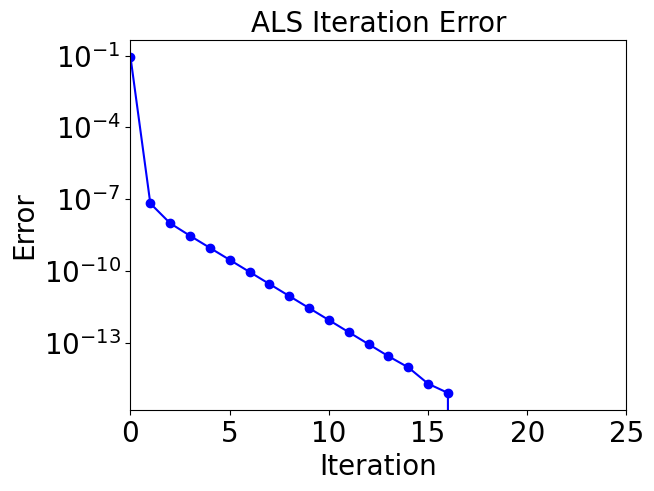

In [15]:
plt.plot(errors, "-ob")
plt.yscale("log")
plt.xlim([0,25])

plt.title("ALS Iteration Error")
plt.ylabel("Error")
plt.xlabel("Iteration")

plt.show()